# Imports

In [74]:
import pandas as pd
import yfinance as yf
from concurrent.futures import ThreadPoolExecutor
import torch
from sklearn import metrics
import matplotlib.pyplot as plt
from datasets import load_dataset
import numpy as np
from datetime import datetime, timedelta
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from newspaper import Article, Config
from transformers import pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# Find n days before or after specified date 

In [2]:
def adjust_date(d, days):
    # Convert string to datetime object
    date = datetime.strptime(d, "%Y-%m-%d")
    
    # Add or subtract days
    adjusted_date = date + timedelta(days=days)
    
    # Convert back to string
    return adjusted_date.strftime("%Y-%m-%d")

# Data loading and cleaning (new dataset)

In [3]:
dataset = load_dataset("edarchimbaud/news-stocks")
dataset.set_format(type='pandas')

df = dataset['train'][:]
df

Using custom data configuration edarchimbaud--news-stocks-37af3a4facfc66df
Found cached dataset parquet (C:/Users/user/.cache/huggingface/datasets/edarchimbaud___parquet/edarchimbaud--news-stocks-37af3a4facfc66df/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

,symbol,body,publisher,publish_time,title,url,uuid
0,A,Vipshop Holdings Limited VIPS is set to report...,Zacks,2023-05-18 16:14:04+00:00,Vipshop (VIPS) to Post Q1 Earnings: What's in ...,https://finance.yahoo.com/news/vipshop-vips-po...,27293957-38d0-3710-8e36-c33a88428202
1,A,"SANTA CLARA, Calif., May 19, 2023--(BUSINESS W...",Business Wire,2023-05-19 01:25:00+00:00,Agilent to Appeal Patent Office Decision on CR...,https://finance.yahoo.com/news/agilent-appeal-...,5477d2fd-f0e0-3721-aeb5-9e4184af5fc1
2,A,Agilent Technologies A is set to report its se...,Zacks,2023-05-19 15:08:03+00:00,Agilent Technologies (A) to Post Q2 Earnings: ...,https://finance.yahoo.com/news/agilent-technol...,619f9fb9-c102-37fc-8b8c-50c11237b9a7
3,A,"Earnings reports from Zoom Video, Lowe’s, Snow...",Barrons.com,2023-05-21 19:00:00+00:00,"Costco, JPMorgan, Snowflake, Ford, Zoom, and M...",https://finance.yahoo.com/m/5f7a781e-1e0c-30b0...,5f7a781e-1e0c-30b0-a052-1d88fc0ce184
4,A,Agilent Technologies A reported second-quarter...,Zacks,2023-05-24 17:17:00+00:00,"Agilent (A) Q2 Earnings Match Estimates, Reven...",https://finance.yahoo.com/news/agilent-q2-earn...,e9307f15-4308-33d8-a649-57f4df3530b1
...,...,...,...,...,...,...,...
22020,ZTS,When considering what names to put on your wat...,Investor's Business Daily,2023-08-09 18:18:00+00:00,Drugmaker Zoetis Stock Shows Rising Relative S...,https://finance.yahoo.com/m/de58f2c0-d31a-310c...,de58f2c0-d31a-310c-a293-02e6c4206e8c
22021,ZTS,"LINCOLN, Neb., August 09, 2023--(BUSINESS WIRE...",Business Wire,2023-08-09 22:33:00+00:00,Zoetis Welcomes Officials to Open New State-of...,https://finance.yahoo.com/news/zoetis-welcomes...,51662184-e4c7-3e7f-a6a2-7b0666de92cd
22022,ZTS,Investors interested in stocks from the Medica...,Zacks,2023-08-10 15:40:11+00:00,USNA or ZTS: Which Is the Better Value Stock R...,https://finance.yahoo.com/news/usna-zts-better...,14a5e82f-6510-30a5-bbf1-cc4982348c42
22023,ZTS,"In this article, we will be taking a look at t...",Insider Monkey,2023-11-09 08:49:40+00:00,Top 20 Drug Companies in the US by Revenue,https://finance.yahoo.com/news/top-20-drug-com...,636f3ccc-872c-3532-ad4b-675b269c4602


In [4]:
df = df.drop(['publisher', 'url', 'uuid'], axis=1)
df

,symbol,body,publish_time,title
0,A,Vipshop Holdings Limited VIPS is set to report...,2023-05-18 16:14:04+00:00,Vipshop (VIPS) to Post Q1 Earnings: What's in ...
1,A,"SANTA CLARA, Calif., May 19, 2023--(BUSINESS W...",2023-05-19 01:25:00+00:00,Agilent to Appeal Patent Office Decision on CR...
2,A,Agilent Technologies A is set to report its se...,2023-05-19 15:08:03+00:00,Agilent Technologies (A) to Post Q2 Earnings: ...
3,A,"Earnings reports from Zoom Video, Lowe’s, Snow...",2023-05-21 19:00:00+00:00,"Costco, JPMorgan, Snowflake, Ford, Zoom, and M..."
4,A,Agilent Technologies A reported second-quarter...,2023-05-24 17:17:00+00:00,"Agilent (A) Q2 Earnings Match Estimates, Reven..."
...,...,...,...,...
22020,ZTS,When considering what names to put on your wat...,2023-08-09 18:18:00+00:00,Drugmaker Zoetis Stock Shows Rising Relative S...
22021,ZTS,"LINCOLN, Neb., August 09, 2023--(BUSINESS WIRE...",2023-08-09 22:33:00+00:00,Zoetis Welcomes Officials to Open New State-of...
22022,ZTS,Investors interested in stocks from the Medica...,2023-08-10 15:40:11+00:00,USNA or ZTS: Which Is the Better Value Stock R...
22023,ZTS,"In this article, we will be taking a look at t...",2023-11-09 08:49:40+00:00,Top 20 Drug Companies in the US by Revenue


In [5]:
# select stocks
ticker = 'AAPL'

df = df[df['symbol'] == ticker]

df = df.reset_index(drop=True)
df

,symbol,body,publish_time,title
0,AAPL,Apple has stopped some of its employees from u...,2023-05-19 12:08:00+00:00,Apple Bans Some Staff From Using ChatGPT. But ...
1,AAPL,Samsung shelved a review that could have seen ...,2023-05-19 13:19:00+00:00,Google Parent Alphabet Stock Rises. It Got Som...
2,AAPL,Nvidia (NVDA) stock has become a Wall Street d...,2023-05-22 12:26:04+00:00,Nvidia stock is trading on 'heroic' valuations...
3,AAPL,Yahoo Finance markets contributor Remy Blaire ...,2023-05-22 20:15:42+00:00,Apple nears $3 trillion market cap amid Loop C...
4,AAPL,Yahoo Finance Senior Reporter Alexandra Canal ...,2023-05-24 16:12:43+00:00,"Streaming wars evolving between Netflix, Disne..."
...,...,...,...,...
91,AAPL,Epic Games is facing a setback in its legal ba...,2023-08-09 19:55:42+00:00,Supreme Court rules in Apple's favor in Epic G...
92,AAPL,As data has taken a backseat in driving market...,2023-08-10 13:33:34+00:00,Tech: Nvidia earnings 'big catalyst' to watch ...
93,AAPL,Apple (AAPL) shares sink in August amid growth...,2023-08-10 16:23:26+00:00,Apple and Nvidia: How the tech stocks are perf...
94,AAPL,"ChatGPT, OpenAI’s text-generating AI chatbot, ...",2023-11-20 07:00:39+00:00,ChatGPT: Everything you need to know about the...


# Load stock prices

In [6]:
# start date is 7 days before the earliest day from the df
# to make sure at least one trading day before is included
# (there might be weekend days/holidays etc.)

start_date = df['publish_time'].min() - timedelta(7)
end_date = df['publish_time'].max() + timedelta(7)

prices = yf.download('AAPL', start_date, end_date)

prices.reset_index(inplace=True)

prices.index = pd.to_datetime(prices.index, format='%Y-%m-%d', utc=True)
prices

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
1970-01-01 00:00:00+00:00,2023-05-12,173.619995,174.059998,171.000000,172.570007,171.891190,45497800
1970-01-01 00:00:00.000000001+00:00,2023-05-15,173.160004,173.210007,171.470001,172.070007,171.393173,37266700
1970-01-01 00:00:00.000000002+00:00,2023-05-16,171.990005,173.139999,171.800003,172.070007,171.393173,42110300
1970-01-01 00:00:00.000000003+00:00,2023-05-17,171.710007,172.929993,170.419998,172.690002,172.010727,57951600
1970-01-01 00:00:00.000000004+00:00,2023-05-18,173.000000,175.240005,172.580002,175.050003,174.361435,65496700
...,...,...,...,...,...,...,...
1970-01-01 00:00:00.000000132+00:00,2023-11-20,189.889999,191.910004,189.880005,191.449997,191.206009,46505100
1970-01-01 00:00:00.000000133+00:00,2023-11-21,191.410004,191.520004,189.740005,190.639999,190.397049,38134500
1970-01-01 00:00:00.000000134+00:00,2023-11-22,191.490005,192.929993,190.830002,191.309998,191.066193,39617700
1970-01-01 00:00:00.000000135+00:00,2023-11-24,190.869995,190.899994,189.250000,189.970001,189.727905,24048300


# News summarization

In [7]:
from transformers import PegasusTokenizer, PegasusForConditionalGeneration, TFPegasusForConditionalGeneration

model_name = "human-centered-summarization/financial-summarization-pegasus"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

In [8]:
def get_summary(text):

  text = text[:512]

  input_ids = tokenizer(text, return_tensors="pt").input_ids

  # Generate the output (Here, we use beam search but you can also use any other strategy you like)
  output = model.generate(
      input_ids,
      max_length=32,
      num_beams=5,
      early_stopping=True
  )

  return tokenizer.decode(output[0], skip_special_tokens=True)

df['summary'] = df['body'].apply(get_summary)
df

,symbol,body,publish_time,title,summary
0,AAPL,Apple has stopped some of its employees from u...,2023-05-19 12:08:00+00:00,Apple Bans Some Staff From Using ChatGPT. But ...,Some employees have been banned from using Cha...
1,AAPL,Samsung shelved a review that could have seen ...,2023-05-19 13:19:00+00:00,Google Parent Alphabet Stock Rises. It Got Som...,Google’s search engine has been removed from S...
2,AAPL,Nvidia (NVDA) stock has become a Wall Street d...,2023-05-22 12:26:04+00:00,Nvidia stock is trading on 'heroic' valuations...,Shares of chip giant are up 115% in 2020 vs. N...
3,AAPL,Yahoo Finance markets contributor Remy Blaire ...,2023-05-22 20:15:42+00:00,Apple nears $3 trillion market cap amid Loop C...,Loop Capital cuts its price target on Apple to...
4,AAPL,Yahoo Finance Senior Reporter Alexandra Canal ...,2023-05-24 16:12:43+00:00,"Streaming wars evolving between Netflix, Disne...","With advertising taking center stage, could we..."
...,...,...,...,...,...
91,AAPL,Epic Games is facing a setback in its legal ba...,2023-08-09 19:55:42+00:00,Supreme Court rules in Apple's favor in Epic G...,"Apple can keep its app store payment rules, Su..."
92,AAPL,As data has taken a backseat in driving market...,2023-08-10 13:33:34+00:00,Tech: Nvidia earnings 'big catalyst' to watch ...,"Nvidia is key to watch for earnings, Lerner says."
93,AAPL,Apple (AAPL) shares sink in August amid growth...,2023-08-10 16:23:26+00:00,Apple and Nvidia: How the tech stocks are perf...,"Apple, Nvidia and more in the news this month."
94,AAPL,"ChatGPT, OpenAI’s text-generating AI chatbot, ...",2023-11-20 07:00:39+00:00,ChatGPT: Everything you need to know about the...,OpenAI’s ChatGPT is used by more than 92% of F...


# Sentiment Analysis

In [9]:
from scipy.special import softmax
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

def sentiment_score(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    scores = outputs.logits[0].detach().numpy()
    scores = softmax(scores)
    return scores


def fetch_sentiments_for_dataframe(df, model, tokenizer):
    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = [executor.submit(sentiment_score, row['title']) for index, row in df.iterrows()]
        sentiments = [future.result() for future in futures]
    return sentiments


df['sentiment_scores'] = fetch_sentiments_for_dataframe(df, model, tokenizer)
df

,symbol,body,publish_time,title,summary,sentiment_scores
0,AAPL,Apple has stopped some of its employees from u...,2023-05-19 12:08:00+00:00,Apple Bans Some Staff From Using ChatGPT. But ...,Some employees have been banned from using Cha...,"[0.014020252, 0.76393914, 0.22204055]"
1,AAPL,Samsung shelved a review that could have seen ...,2023-05-19 13:19:00+00:00,Google Parent Alphabet Stock Rises. It Got Som...,Google’s search engine has been removed from S...,"[0.6117223, 0.11752819, 0.27074948]"
2,AAPL,Nvidia (NVDA) stock has become a Wall Street d...,2023-05-22 12:26:04+00:00,Nvidia stock is trading on 'heroic' valuations...,Shares of chip giant are up 115% in 2020 vs. N...,"[0.059000984, 0.086460315, 0.8545387]"
3,AAPL,Yahoo Finance markets contributor Remy Blaire ...,2023-05-22 20:15:42+00:00,Apple nears $3 trillion market cap amid Loop C...,Loop Capital cuts its price target on Apple to...,"[0.025485057, 0.9548232, 0.019691786]"
4,AAPL,Yahoo Finance Senior Reporter Alexandra Canal ...,2023-05-24 16:12:43+00:00,"Streaming wars evolving between Netflix, Disne...","With advertising taking center stage, could we...","[0.031807497, 0.07774759, 0.89044493]"
...,...,...,...,...,...,...
91,AAPL,Epic Games is facing a setback in its legal ba...,2023-08-09 19:55:42+00:00,Supreme Court rules in Apple's favor in Epic G...,"Apple can keep its app store payment rules, Su...","[0.1398805, 0.2102882, 0.6498314]"
92,AAPL,As data has taken a backseat in driving market...,2023-08-10 13:33:34+00:00,Tech: Nvidia earnings 'big catalyst' to watch ...,"Nvidia is key to watch for earnings, Lerner says.","[0.24416764, 0.013330109, 0.7425022]"
93,AAPL,Apple (AAPL) shares sink in August amid growth...,2023-08-10 16:23:26+00:00,Apple and Nvidia: How the tech stocks are perf...,"Apple, Nvidia and more in the news this month.","[0.07990647, 0.11852201, 0.80157137]"
94,AAPL,"ChatGPT, OpenAI’s text-generating AI chatbot, ...",2023-11-20 07:00:39+00:00,ChatGPT: Everything you need to know about the...,OpenAI’s ChatGPT is used by more than 92% of F...,"[0.04002294, 0.018011685, 0.9419654]"


# Calculate trends and predicted trends

In [10]:
def trend(date):
    if pd.isnull(date):
        return 'stable'  # Or any default value you see fit

    # Ensure prev_date is not NaT
    prev_date = prices[prices.index < date].index.max()
    if pd.isnull(prev_date):
        return 'stable'  # No previous date found

    try:
        prev_date_index = prices.index.get_loc(prev_date.strftime('%Y-%m-%d'))
    except ValueError:
        prev_date_index = prices.index.get_loc(prev_date)

    if pd.isnull(prev_date_index):
        return 'stable'  # Handle case where prev_date_index is NaT or not found

    # Ensure next_date is not NaT
    next_date = prices[prices.index > date].index.min()
    if pd.isnull(next_date):
        return 'stable'  # No next date found

    try:
        next_date_index = prices.index.get_loc(next_date.strftime('%Y-%m-%d'))
    except ValueError:
        next_date_index = prices.index.get_loc(next_date)

    ret = ((prices['Open'][next_date_index] - prices['Close'][prev_date_index]) / prices['Close'][prev_date_index]) * 100

    return_threshold = 1.0  # (1%)
    if ret >= return_threshold:
        return 'increase'
    elif ret <= -return_threshold:
        return 'decrease'
    else:
        return 'stable'
    
def predicted_trend(sentiment_score):
  sentiment_threshold = 0.7 # (70%)
  if sentiment_score[0] >= sentiment_threshold:
    return 'increase'
  elif sentiment_score[1] >= sentiment_threshold:
    return 'decrease'
  else:
    return 'stable'

df['trend'] = df['publish_time'].apply(trend)
df['predicted_trend'] = df['sentiment_scores'].apply(predicted_trend)
df

,symbol,body,publish_time,title,summary,sentiment_scores,trend,predicted_trend
0,AAPL,Apple has stopped some of its employees from u...,2023-05-19 12:08:00+00:00,Apple Bans Some Staff From Using ChatGPT. But ...,Some employees have been banned from using Cha...,"[0.014020252, 0.76393914, 0.22204055]",stable,decrease
1,AAPL,Samsung shelved a review that could have seen ...,2023-05-19 13:19:00+00:00,Google Parent Alphabet Stock Rises. It Got Som...,Google’s search engine has been removed from S...,"[0.6117223, 0.11752819, 0.27074948]",stable,stable
2,AAPL,Nvidia (NVDA) stock has become a Wall Street d...,2023-05-22 12:26:04+00:00,Nvidia stock is trading on 'heroic' valuations...,Shares of chip giant are up 115% in 2020 vs. N...,"[0.059000984, 0.086460315, 0.8545387]",stable,stable
3,AAPL,Yahoo Finance markets contributor Remy Blaire ...,2023-05-22 20:15:42+00:00,Apple nears $3 trillion market cap amid Loop C...,Loop Capital cuts its price target on Apple to...,"[0.025485057, 0.9548232, 0.019691786]",stable,decrease
4,AAPL,Yahoo Finance Senior Reporter Alexandra Canal ...,2023-05-24 16:12:43+00:00,"Streaming wars evolving between Netflix, Disne...","With advertising taking center stage, could we...","[0.031807497, 0.07774759, 0.89044493]",stable,stable
...,...,...,...,...,...,...,...,...
91,AAPL,Epic Games is facing a setback in its legal ba...,2023-08-09 19:55:42+00:00,Supreme Court rules in Apple's favor in Epic G...,"Apple can keep its app store payment rules, Su...","[0.1398805, 0.2102882, 0.6498314]",stable,stable
92,AAPL,As data has taken a backseat in driving market...,2023-08-10 13:33:34+00:00,Tech: Nvidia earnings 'big catalyst' to watch ...,"Nvidia is key to watch for earnings, Lerner says.","[0.24416764, 0.013330109, 0.7425022]",stable,stable
93,AAPL,Apple (AAPL) shares sink in August amid growth...,2023-08-10 16:23:26+00:00,Apple and Nvidia: How the tech stocks are perf...,"Apple, Nvidia and more in the news this month.","[0.07990647, 0.11852201, 0.80157137]",stable,stable
94,AAPL,"ChatGPT, OpenAI’s text-generating AI chatbot, ...",2023-11-20 07:00:39+00:00,ChatGPT: Everything you need to know about the...,OpenAI’s ChatGPT is used by more than 92% of F...,"[0.04002294, 0.018011685, 0.9419654]",stable,stable


# Get sentiment labels

In [11]:
def get_sentiment_label(sentiment_scores):
    max_index = np.argmax(sentiment_scores)
    if max_index == 0:
        return -1
    elif max_index == 1:
        return 0
    else:
        return 1

# Assuming df is your dataframe and 'sentiment_scores' is the column containing sentiment scores
df['sentiment_label'] = df['sentiment_scores'].apply(get_sentiment_label)
df    

,symbol,body,publish_time,title,summary,sentiment_scores,trend,predicted_trend,sentiment_label
0,AAPL,Apple has stopped some of its employees from u...,2023-05-19 12:08:00+00:00,Apple Bans Some Staff From Using ChatGPT. But ...,Some employees have been banned from using Cha...,"[0.014020252, 0.76393914, 0.22204055]",stable,decrease,0
1,AAPL,Samsung shelved a review that could have seen ...,2023-05-19 13:19:00+00:00,Google Parent Alphabet Stock Rises. It Got Som...,Google’s search engine has been removed from S...,"[0.6117223, 0.11752819, 0.27074948]",stable,stable,-1
2,AAPL,Nvidia (NVDA) stock has become a Wall Street d...,2023-05-22 12:26:04+00:00,Nvidia stock is trading on 'heroic' valuations...,Shares of chip giant are up 115% in 2020 vs. N...,"[0.059000984, 0.086460315, 0.8545387]",stable,stable,1
3,AAPL,Yahoo Finance markets contributor Remy Blaire ...,2023-05-22 20:15:42+00:00,Apple nears $3 trillion market cap amid Loop C...,Loop Capital cuts its price target on Apple to...,"[0.025485057, 0.9548232, 0.019691786]",stable,decrease,0
4,AAPL,Yahoo Finance Senior Reporter Alexandra Canal ...,2023-05-24 16:12:43+00:00,"Streaming wars evolving between Netflix, Disne...","With advertising taking center stage, could we...","[0.031807497, 0.07774759, 0.89044493]",stable,stable,1
...,...,...,...,...,...,...,...,...,...
91,AAPL,Epic Games is facing a setback in its legal ba...,2023-08-09 19:55:42+00:00,Supreme Court rules in Apple's favor in Epic G...,"Apple can keep its app store payment rules, Su...","[0.1398805, 0.2102882, 0.6498314]",stable,stable,1
92,AAPL,As data has taken a backseat in driving market...,2023-08-10 13:33:34+00:00,Tech: Nvidia earnings 'big catalyst' to watch ...,"Nvidia is key to watch for earnings, Lerner says.","[0.24416764, 0.013330109, 0.7425022]",stable,stable,1
93,AAPL,Apple (AAPL) shares sink in August amid growth...,2023-08-10 16:23:26+00:00,Apple and Nvidia: How the tech stocks are perf...,"Apple, Nvidia and more in the news this month.","[0.07990647, 0.11852201, 0.80157137]",stable,stable,1
94,AAPL,"ChatGPT, OpenAI’s text-generating AI chatbot, ...",2023-11-20 07:00:39+00:00,ChatGPT: Everything you need to know about the...,OpenAI’s ChatGPT is used by more than 92% of F...,"[0.04002294, 0.018011685, 0.9419654]",stable,stable,1


# Results

   symbol                                               body  \
0    AAPL  Apple has stopped some of its employees from u...   
1    AAPL  Samsung shelved a review that could have seen ...   
2    AAPL  Nvidia (NVDA) stock has become a Wall Street d...   
3    AAPL  Yahoo Finance markets contributor Remy Blaire ...   
4    AAPL  Yahoo Finance Senior Reporter Alexandra Canal ...   
..    ...                                                ...   
91   AAPL  Epic Games is facing a setback in its legal ba...   
92   AAPL  As data has taken a backseat in driving market...   
93   AAPL  Apple (AAPL) shares sink in August amid growth...   
94   AAPL  ChatGPT, OpenAI’s text-generating AI chatbot, ...   
95   AAPL  (Bloomberg) -- Epic Games Inc. Chief Executive...   

                publish_time  \
0  2023-05-19 12:08:00+00:00   
1  2023-05-19 13:19:00+00:00   
2  2023-05-22 12:26:04+00:00   
3  2023-05-22 20:15:42+00:00   
4  2023-05-24 16:12:43+00:00   
..                       ...   
91 2023

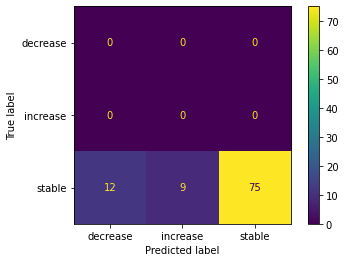

In [12]:
print(df)
confusion_matrix = metrics.confusion_matrix(df['trend'], df['predicted_trend'])

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['decrease', 'increase', 'stable'])

cm_display.plot()
plt.show()

# Calculate the trend accuracy and average sentiment score

In [80]:
df['average_sentiment_score'] = df['sentiment_scores'].apply(lambda x: sum(x) / len(x))

# Count articles by sentiment
df['sentiment'] = pd.cut(df['average_sentiment_score'], bins=[-1, 0.33, 0.66, 1], labels=['negative', 'neutral', 'positive'])

# Compute trend accuracy
accuracy = metrics.accuracy_score(df['trend'], df['predicted_trend'])

print("Average Sentiment Score:", df['average_sentiment_score'].iloc[0])
print("Trend Accuracy:", accuracy)
df.drop(columns=["average_sentiment_score"])

Average Sentiment Score: 0.333333314396441
Trend Accuracy: 0.78125


,symbol,body,publish_time,title,summary,sentiment_scores,trend,predicted_trend,sentiment_label,sentiment
0,AAPL,Apple has stopped some of its employees from u...,2023-05-19 12:08:00+00:00,Apple Bans Some Staff From Using ChatGPT. But ...,Some employees have been banned from using Cha...,"[0.014020252, 0.76393914, 0.22204055]",stable,decrease,0,neutral
1,AAPL,Samsung shelved a review that could have seen ...,2023-05-19 13:19:00+00:00,Google Parent Alphabet Stock Rises. It Got Som...,Google’s search engine has been removed from S...,"[0.6117223, 0.11752819, 0.27074948]",stable,stable,-1,neutral
2,AAPL,Nvidia (NVDA) stock has become a Wall Street d...,2023-05-22 12:26:04+00:00,Nvidia stock is trading on 'heroic' valuations...,Shares of chip giant are up 115% in 2020 vs. N...,"[0.059000984, 0.086460315, 0.8545387]",stable,stable,1,neutral
3,AAPL,Yahoo Finance markets contributor Remy Blaire ...,2023-05-22 20:15:42+00:00,Apple nears $3 trillion market cap amid Loop C...,Loop Capital cuts its price target on Apple to...,"[0.025485057, 0.9548232, 0.019691786]",stable,decrease,0,neutral
4,AAPL,Yahoo Finance Senior Reporter Alexandra Canal ...,2023-05-24 16:12:43+00:00,"Streaming wars evolving between Netflix, Disne...","With advertising taking center stage, could we...","[0.031807497, 0.07774759, 0.89044493]",stable,stable,1,neutral
...,...,...,...,...,...,...,...,...,...,...
91,AAPL,Epic Games is facing a setback in its legal ba...,2023-08-09 19:55:42+00:00,Supreme Court rules in Apple's favor in Epic G...,"Apple can keep its app store payment rules, Su...","[0.1398805, 0.2102882, 0.6498314]",stable,stable,1,neutral
92,AAPL,As data has taken a backseat in driving market...,2023-08-10 13:33:34+00:00,Tech: Nvidia earnings 'big catalyst' to watch ...,"Nvidia is key to watch for earnings, Lerner says.","[0.24416764, 0.013330109, 0.7425022]",stable,stable,1,neutral
93,AAPL,Apple (AAPL) shares sink in August amid growth...,2023-08-10 16:23:26+00:00,Apple and Nvidia: How the tech stocks are perf...,"Apple, Nvidia and more in the news this month.","[0.07990647, 0.11852201, 0.80157137]",stable,stable,1,neutral
94,AAPL,"ChatGPT, OpenAI’s text-generating AI chatbot, ...",2023-11-20 07:00:39+00:00,ChatGPT: Everything you need to know about the...,OpenAI’s ChatGPT is used by more than 92% of F...,"[0.04002294, 0.018011685, 0.9419654]",stable,stable,1,neutral


# Merge dataframes based on date, removing records where dates are missing

In [ ]:
df['publish_time'] = pd.to_datetime(df['publish_time'], utc=True)

# Convert 'Date' column to datetime with UTC timezone
prices['Date'] = pd.to_datetime(prices['Date']).dt.tz_localize('UTC')

# Now perform the merge
merged_df = pd.merge_asof(df, prices, left_on='publish_time', right_on='Date', direction='nearest')

# Display the merged DataFrame
matched_records_df = merged_df[merged_df['Date'].dt.date == merged_df['publish_time'].dt.date]


# Feature engineering: combine sentiment label and date
# Assuming sentiment_label is already encoded (if necessary)
features = matched_records_df[['sentiment_label', 'Date']]

# Convert 'Date' to datetime format
matched_records_df.loc[:, 'Date'] = pd.to_datetime(matched_records_df['Date'])

# Extract 'Year', 'Month', and 'Day' as separate columns using .loc
matched_records_df.loc[:, 'Year'] = matched_records_df['Date'].dt.year
matched_records_df.loc[:, 'Month'] = matched_records_df['Date'].dt.month
matched_records_df.loc[:, 'Day'] = matched_records_df['Date'].dt.day

# Now use these new columns as features instead of the 'Date' column
features = matched_records_df[['sentiment_label', 'Year', 'Month', 'Day']]


# Target variable
target = matched_records_df['Close']

# Split the data into training and testing sets

#print(matched_records_df.size)
#print(target)
#print(features)

# Training ML models and calculating metrics

In [82]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
#print(len(X_test))

# Train the model
models = {
    'RandomForestRegressor': RandomForestRegressor(random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
    'LinearRegression': LinearRegression(),
    'SVR': SVR()
}

# Loop through the models
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Compute metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Print results
    print(f"Results for {name}:")
    print(f"  Mean Absolute Error (MAE): {mae}")
    print(f"  Mean Squared Error (MSE): {mse}")
    print(f"  Root Mean Squared Error (RMSE): {rmse}")
    print(f"  R-squared (R²) score: {r2}\n")


Results for RandomForestRegressor:
  Mean Absolute Error (MAE): 2.316415588378908
  Mean Squared Error (MSE): 7.887862476714882
  Root Mean Squared Error (RMSE): 2.8085338660437906
  R-squared (R²) score: 0.656855306384766

Results for GradientBoostingRegressor:
  Mean Absolute Error (MAE): 1.7384632358593421
  Mean Squared Error (MSE): 7.540348647360743
  Root Mean Squared Error (RMSE): 2.745969527755314
  R-squared (R²) score: 0.6719731569878671

Results for LinearRegression:
  Mean Absolute Error (MAE): 3.14192865662161
  Mean Squared Error (MSE): 11.721234825530901
  Root Mean Squared Error (RMSE): 3.4236288971690407
  R-squared (R²) score: 0.49009258910480935

Results for SVR:
  Mean Absolute Error (MAE): 4.273979144794697
  Mean Squared Error (MSE): 23.068726917466776
  Root Mean Squared Error (RMSE): 4.802991455069098
  R-squared (R²) score: -0.003555938450442886

